In [1]:
# Imports for plotting, data manipulation, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
# Dataframe imports and droppin unnecessary columns
file = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_batting_df.csv'
file2 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_piching_df.csv'
file3 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_game_df.csv'
batting_df = pd.read_csv(file)
pitching_df = pd.read_csv(file2)
game_df = pd.read_csv(file3)
batting_df.drop('Unnamed: 0', axis=1, inplace=True)
pitching_df.drop('Unnamed: 0', axis=1, inplace=True)
game_df.drop('Unnamed: 0', axis=1, inplace=True)

## Batting Feature engineering ideas
- All of these stats will be on a PER PLATE APPEARANCE then divide by 162 to get PER GAME STATS
    - Team stats will be summed up and averaged - Will ultimately be compared to a teams 7 day trends history
        - 'totalBases' / total 'plateAppearances' - DONE
        - 'leftonbase'/ total 'plateAppearances' - DONE
        - 'runs' / total 'plateAppearances' - DONE
        - 'strikeOuts' / total 'atBats' - DONE
        - 'baseOnBalls' + 'intentionalWalks' / total 'plateAppearances' - DONE
            - 'hits' / total 'atBats' --- Leverage for game_df. get team stats per game...
            - 'obp' / # of batters on team --- Same as above
        - 'rbi' / total 'atBats' - DONE

In [5]:
# MIA & FLO are different. Standardizing to MIA
batting_df.replace(to_replace='FLA', value='MIA', inplace=True)

### Create New Features for TEAM stats

In [7]:
# THIS IS THE FRAMEWORK TO GENERATE TEAM STATISTICS...
# Creating a dataframe containing team annual Batting Averages

a = batting_df.groupby(['year', 'teamAbbrev'])['hits'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
BA = a.join(b, on=['year', 'teamAbbrev'])
BA['team_BA'] = round((BA['hits']/BA['atBats']), 3)
# BA = BA.reset_index()

In [8]:
# Total bases per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['totalBases'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
TB = a.join(b, on=['year', 'teamAbbrev'])
TB['total_bases_avg'] = round((TB['totalBases']/TB['plateAppearances']), 3)
# TB = TB.reset_index()

In [9]:
# LOB per plate appearnace

a = batting_df.groupby(['year', 'teamAbbrev'])['leftOnBase'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
LOB = a.join(b, on=['year', 'teamAbbrev'])
LOB['LOB_avg'] = round((LOB['leftOnBase']/LOB['plateAppearances']), 3)
# LOB = LOB.reset_index()

In [10]:
# Runs per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['runs'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RUNS = a.join(b, on=['year', 'teamAbbrev'])
RUNS['runs_avg'] = round((RUNS['runs']/RUNS['plateAppearances']), 3)
# RUNS = RUNS.reset_index()

In [11]:
# K's per AtBat

a = batting_df.groupby(['year', 'teamAbbrev'])['strikeOuts'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
K = a.join(b, on=['year', 'teamAbbrev'])
K['K_avg'] = round((K['strikeOuts']/K['atBats']), 3)
# K = K.reset_index()

In [12]:
# BB per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['baseOnBalls'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BB = a.join(b, on=['year', 'teamAbbrev'])
BB['BB_avg'] = round((BB['baseOnBalls']/BB['plateAppearances']), 3)
# BB = BB.reset_index()

In [13]:
# RBI per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['rbi'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RBI = a.join(b, on=['year', 'teamAbbrev'])
RBI['RBI_avg'] = round((RBI['rbi']/RBI['plateAppearances']), 3)
# RBI = RBI.reset_index()

## Merge all the TEAM stats into one dataframe

In [14]:
team_stats_lst = [BA, TB, LOB, RUNS, K, BB, RBI]

In [15]:
team_stats = pd.concat(team_stats_lst, join='outer', axis=1)

In [16]:
team_stats = team_stats.reset_index()

In [17]:
team_stats.columns

Index(['year', 'teamAbbrev', 'hits', 'atBats', 'team_BA', 'totalBases',
       'plateAppearances', 'total_bases_avg', 'leftOnBase', 'plateAppearances',
       'LOB_avg', 'runs', 'plateAppearances', 'runs_avg', 'strikeOuts',
       'atBats', 'K_avg', 'baseOnBalls', 'plateAppearances', 'BB_avg', 'rbi',
       'plateAppearances', 'RBI_avg'],
      dtype='object')

## Pitching Feature ideas
- Pitching stats will focus on starting pitchers Per9 innings stat (except for certain features)
    - 'winningPercentage'
    - 'runsScoredPer9'
    - 'hitsPer9'
    - 'era'
    - 'whip'

In [18]:
# Rearrange the pitching_df so the columns have a better flow
pitching_df = pitching_df.reindex(columns=['year','playerName','teamAbbrev','winningPercentage','runsScoredPer9','hitsPer9','strikeoutsPer9','baseOnBallsPer9','homeRunsPer9','era','whip','ops','gidp','avg'])
# Columns to be left out from the reindexing --- 'winPercentage', 'strikeoutsPer9Inn', 'walksPer9Inn', 'hitsPer9Inn'

In [19]:
# Marlins have the team labels: MIA & FLO. Standardizing to MIA
pitching_df.replace(to_replace='FLA', value='MIA', inplace=True)

In [20]:
# 31 teams showing up since it seems like there are some NaN values for team names.
# Will deal with should it become an issue...
len(pitching_df.teamAbbrev.unique())

31

## Game DF Feature ideas
- Turn VisitorRunsScored & HomeRunsScore into a column that indicates if the home team won - DONE.
- Combine VisitorHBP & VisitorBB & VisitorIBB into a single column containing all the stats - DONE.
- Same with HomeHBP & HomeBB & HomeIBB - DONE.
<br/><br/>
- Combine VisitorH / VisitorAB = team_BA - DONE.
- Same with HomeH / HomeAB - DONE. 
<br/><br/>
- Eventually add on all the other engineered features into this dataframe...
<br/><br/>
- Since the game_df has a date column, I'd like to leverage that to look at 7-day-trends, 14-day-trends, etc

In [21]:
# Creating a Target for the model to eventually train on
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']

In [22]:
# Adding a Home & Away BA per game to compare batting trends over time
game_df['Visitor_BA'] = round((game_df['VisitorH'] / game_df['VisitorAB']), 3)
game_df['Home_BA'] = round((game_df['HomeH'] / game_df['HomeAB']), 3)

In [23]:
# Creating a new column in order to add Date/Time to my dataframe
game_df['New_Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')

In [24]:
# Rearranging columns so new date/time is at the front of the DF & dropping old date column since it was an integer
game_df = game_df.reindex(columns=['New_Date','Date', 'VisitingTeam','VisitorStartingPitcherName','HomeTeam','HomeStartingPitcherName', 'VisitorRunsScored','HomeRunsScore', 'VisitorAB', 'VisitorH','Visitor_BA', 'VisitorHBP', 'VisitorBB','VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?'])
game_df.drop('Date', axis='columns', inplace=True)

In [25]:
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)

In [26]:
# Adding a prior year column in order to match last seasons stats from pitching_df/team_stats to game_df
game_df['prior_year'] = game_df['New_Date'].dt.year-1

## Merge pitching_df stats to game_df

In [27]:
# Merging the pitching stats on the prior year in the game_df in order to leverage the pitchers 
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','VisitorStartingPitcherName'], right_on=['year', 'playerName'])

In [28]:
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','HomeStartingPitcherName'], right_on=['year', 'playerName'])

## Merge Team Batting stats to game_df

In [29]:
team_stats.head()

,year,teamAbbrev,hits,atBats,team_BA,totalBases,plateAppearances,total_bases_avg,leftOnBase,plateAppearances,...,runs_avg,strikeOuts,atBats,K_avg,baseOnBalls,plateAppearances,BB_avg,rbi,plateAppearances,RBI_avg
0,2009,ARI,1310,5182,0.253,2195,5858,0.375,2225,5858,...,0.116,1224,5182,0.236,545,5858,0.093,664,5858,0.113
1,2009,ATL,1492,5678,0.263,2336,6510,0.359,2432,6510,...,0.119,1137,5678,0.200,637,6510,0.098,723,6510,0.111
2,2009,BAL,1367,5073,0.269,2107,5610,0.376,2132,5610,...,0.120,913,5073,0.180,449,5610,0.080,628,5610,0.112
3,2009,BOS,1915,7202,0.266,3151,8245,0.382,3223,8245,...,0.128,1435,7202,0.199,864,8245,0.105,1036,8245,0.126
4,2009,CHC,1392,5459,0.255,2228,6214,0.359,2458,6214,...,0.113,1176,5459,0.215,590,6214,0.095,679,6214,0.109


In [30]:
# Dropping redundant columns from batting stats df
team_stats.drop('plateAppearances', axis=1, inplace=True)

In [31]:
# Merging away team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'VisitingTeam'], right_on=['year', 'teamAbbrev'])

In [32]:
# Merging home team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'HomeTeam'], right_on=['year', 'teamAbbrev'])

In [33]:
# Creating an integer reference point in game_df
game_df['current_year'] = game_df['New_Date'].dt.year

In [34]:
# Addressing NaN values in game_df by giving them a -1 score
# NaN indicates that the player did not have stats from the prior year to measure againsta
game_df.fillna(value = -1, inplace=True)

In [35]:
# Checking game_df for ANY NaN values
game_df.isnull().values.any()
# Returns false, indicating that there are NO NaN values in the game_df

False

In [36]:
game_df.columns

Index(['New_Date', 'VisitingTeam', 'VisitorStartingPitcherName', 'HomeTeam',
       'HomeStartingPitcherName', 'VisitorRunsScored', 'HomeRunsScore',
       'VisitorAB', 'VisitorH', 'Visitor_BA', 'VisitorHBP', 'VisitorBB',
       'VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP',
       'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?', 'prior_year',
       'year_x', 'playerName_x', 'teamAbbrev_x', 'winningPercentage_x',
       'runsScoredPer9_x', 'hitsPer9_x', 'strikeoutsPer9_x',
       'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x', 'whip_x', 'ops_x',
       'gidp_x', 'avg_x', 'year_y', 'playerName_y', 'teamAbbrev_y',
       'winningPercentage_y', 'runsScoredPer9_y', 'hitsPer9_y',
       'strikeoutsPer9_y', 'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y',
       'whip_y', 'ops_y', 'gidp_y', 'avg_y', 'year_x', 'teamAbbrev_x',
       'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x', 'total_bases_avg_x',
       'leftOnBase_x', 'LOB_avg_x', 'runs_x', 'runs_avg_x', 'strike

In [37]:
game_df

,New_Date,VisitingTeam,VisitorStartingPitcherName,HomeTeam,HomeStartingPitcherName,VisitorRunsScored,HomeRunsScore,VisitorAB,VisitorH,Visitor_BA,...,runs_y,runs_avg_y,strikeOuts_y,atBats_y,K_avg_y,baseOnBalls_y,BB_avg_y,rbi_y,RBI_avg_y,current_year
0,2010-04-04,NYY,CC Sabathia,BOS,Josh Beckett,7,9,37,12,0.324,...,1057.0,0.128,1435.0,7202.0,0.199,864.0,0.105,1036.0,0.126,2010
1,2010-04-05,MIN,Scott Baker,LAA,Jered Weaver,3,6,32,7,0.219,...,879.0,0.140,1047.0,5597.0,0.187,544.0,0.087,837.0,0.133,2010
2,2010-04-05,CLE,Jake Westbrook,CWS,Mark Buehrle,0,6,30,4,0.133,...,707.0,0.115,959.0,5518.0,0.174,491.0,0.080,686.0,0.111,2010
3,2010-04-05,DET,Justin Verlander,KC,Zack Greinke,8,4,39,12,0.308,...,715.0,0.110,1119.0,5876.0,0.190,471.0,0.073,692.0,0.107,2010
4,2010-04-05,SEA,Felix Hernandez,OAK,Ben Sheets,5,3,31,6,0.194,...,641.0,0.124,887.0,4635.0,0.191,410.0,0.080,609.0,0.118,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24295,2019-09-29,DET,Spencer Turnbull,CWS,Ross Detwiler,3,5,31,7,0.226,...,641.0,0.107,1608.0,5448.0,0.295,423.0,0.071,626.0,0.105,2019
24296,2019-09-29,MIN,Martin Perez,KC,Jorge Lopez,4,5,32,6,0.188,...,522.0,0.107,1092.0,4425.0,0.247,349.0,0.072,472.0,0.097,2019
24297,2019-09-29,OAK,Tanner Roark,SEA,Justin Dunn,1,3,30,3,0.100,...,722.0,0.111,1294.0,5891.0,0.220,487.0,0.075,692.0,0.106,2019
24298,2019-09-29,NYY,Chad Green,TEX,Lance Lynn,1,6,30,3,0.100,...,736.0,0.119,1491.0,5469.0,0.273,560.0,0.091,694.0,0.112,2019


In [38]:
game_df.gidp_y

0        14.0
1         5.0
2        28.0
3        17.0
4        -1.0
         ... 
24295     5.0
24296     3.0
24297    -1.0
24298    13.0
24299     9.0
Name: gidp_y, Length: 24300, dtype: float64

## Train and fit a model to see how these feature perform so far...

#### First model being trained will be on the teams/starting pitcher prior year statistics

In [39]:
# Creating an initial drop_lst variable to use for dropping metrics that are answers...
drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year']

In [40]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)

In [41]:
def my_train_test_split(X, y, start_year, end_year):
    '''
    creating a custom train_test_split in order to split data by seasons
    i.e.
    - train on 2010-2016 seasons
    - test on 2018-2019 seasons
    
    Parameters:
    X: features
    y: target value
    
    returns:
    X_train, X_test, y_train, y_test
    '''
    # There are objects in the DF that need to be numeric values
    # obj_lst = ['winningPercentage_x','runsScoredPer9_x','hitsPer9_x','strikeoutsPer9_x','baseOnBallsPer9_x','homeRunsPer9_x','era_x','whip_x','winningPercentage_y','runsScoredPer9_y','hitsPer9_y','strikeoutsPer9_y','baseOnBallsPer9_y','homeRunsPer9_y','era_y','whip_y']

    # Getting X values to_numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(value = -1, inplace=True)
    
                    # THIS WAS THE LINE ADDED THAT MESSED STUFF UP!!!!!!!!
    #Adding a drop y step to the function to make the tweaked version later work better
#     y = y.loc[y['current_year'] <= end_year+1]
#     y = y['Home_team_won?']
    
    
    # Setting up how to break up seasons by years
    years = np.arange(start_year, end_year+1)
    mask = game_df['current_year'].isin(years)
    
    # Splitting between the training & testing sets
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]

    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [43]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'atBats_y', 'team_BA_y',
       'totalBases_y', 'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y',
       'runs_y', 'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y',
       'baseOnBalls_y', 'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year'],
      dtype='object')

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [45]:
# True indicates that the Home TEAM WON, 
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,907,1384
True,799,1770


In [46]:
print(f"Accuracy of historic stats: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy of historic stats: 55.08%


In [47]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.54%


In [48]:
def plot_features_importance(model, color):
    '''
    A funciton to plot my feature importances
    
    parameter:
    model - the variable that we fit our model to. i.e. RF = RandomForest()
    color - a string that will assign the graphs color scheme
    
    ex: rf = RandomForestClassifier()
    model = rf
    
    returns:
    a plot highlighting feature importance
    '''
    model.feature_importances_
    importances = pd.Series(data=model.feature_importances_, index= X_train.columns)
    importances_sorted = importances.sort_values()
    importances_sorted.plot(kind='barh', color=color, figsize=(15,10))

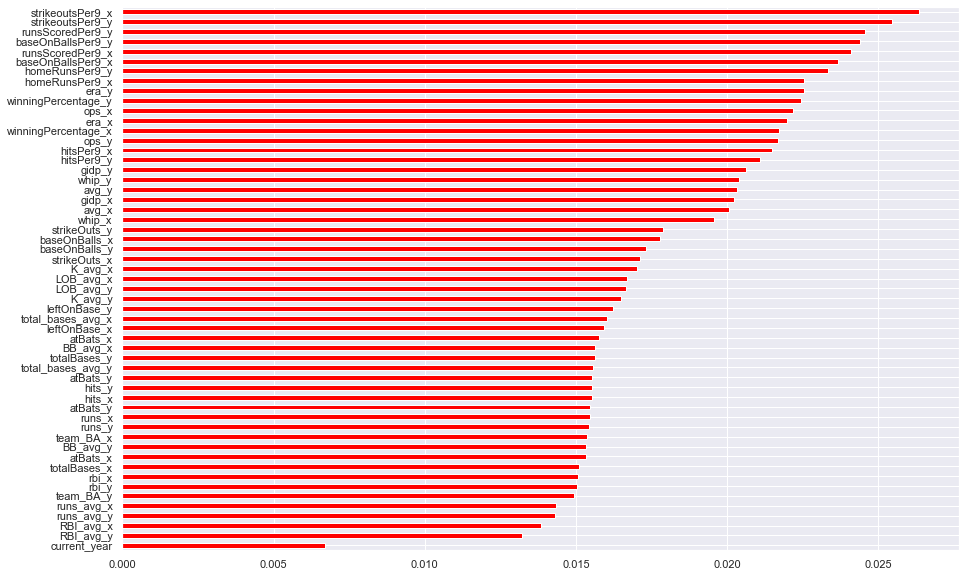

In [49]:
# Generating feature importance from prior year team offensive stats as well as starting pitchers stats
plot_features_importance(rf, "red")

## Adding a rolling 3-day & 7-day average for teams:
- Batting averages ( sum(Hits) / sum(AtBats) )
    - DONE!!! 
- LOB averages ( sum(LOB) / sum(AtBats + BB + IBB + HBP) ) # denom is sum of plate appearances
    - Holding off for now...
- Run averages ( sum(runs) / 7-games )
    - DONE!!!
- OBP averages ( sum(Hits + BB + IBB + HBP) / sum(AtBats + BB + IBB + HBP) ) # denom is sum of plate appearances
    - DONE!!!

## Create Home & Away OBP stats

In [50]:
game_df['Visitor_OBP'] = round((game_df['VisitorH'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']) / (game_df['VisitorAB'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']), 3)
game_df['Home_OBP'] = round((game_df['HomeH'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']) / (game_df['HomeAB'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']), 3)

## Create Home & Away 3d & 7d OBP trends

In [51]:
game_df['3d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d scoring trends

In [52]:
game_df['3d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d Batting Average trends

In [53]:
game_df['3d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

#### Seems like everything worked... now to train and test different models with the additional engineered features

In [54]:
# Created a 2nd drop_lst2 to take out additional columns that were created for previous modeling
drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP',
'winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
'BB_avg_y', 'rbi_y', 'RBI_avg_y', ]

In [55]:
three_day_trends = ['3d_homeOBP_avg', '3d_visitorOBP_avg', '3d_homescore_avg', '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA']

In [56]:
seven_day_trends = ['7d_homeOBP_avg','7d_visitorOBP_avg','7d_homescore_avg','7d_visitorscore_avg','7d_homeBA','7d_visitorBA']

## Test on 3d trends first

In [57]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)
X = X.drop(seven_day_trends, axis=1)

In [58]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [59]:
X_train.columns

Index(['current_year', '3d_homeOBP_avg', '3d_visitorOBP_avg',
       '3d_homescore_avg', '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA'],
      dtype='object')

In [60]:
rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)

In [61]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,805,1486
True,929,1640


In [62]:
print(f"Accuracy for 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 3d trends: 50.31%


In [63]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf2, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 50.74%


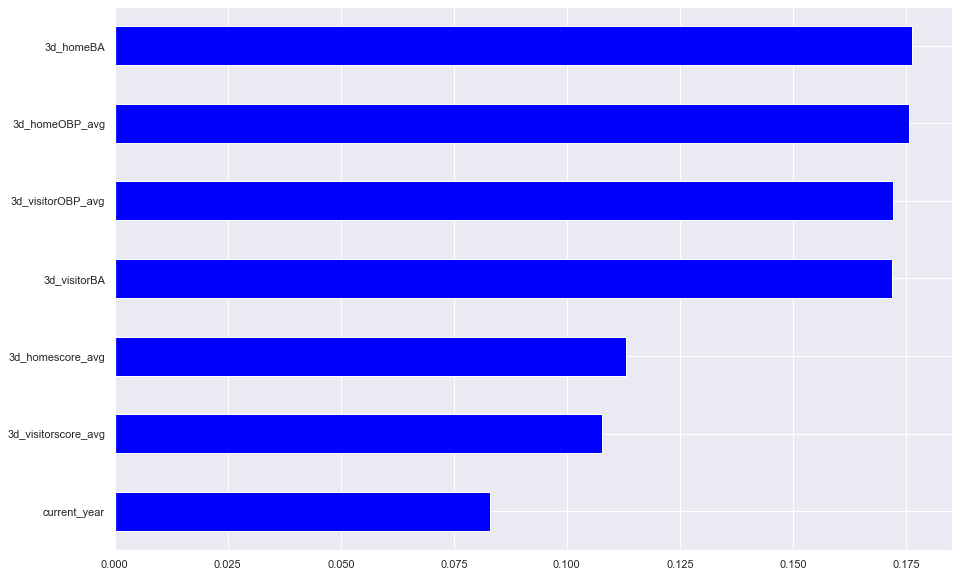

In [64]:
plot_features_importance(rf2, "blue")

## Now test 7d trends

In [65]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)
X = X.drop(three_day_trends, axis=1)

In [66]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [67]:
X_train.columns

Index(['current_year', '7d_homeOBP_avg', '7d_visitorOBP_avg',
       '7d_homescore_avg', '7d_visitorscore_avg', '7d_homeBA', '7d_visitorBA'],
      dtype='object')

In [68]:
rf2_7 = RandomForestClassifier()
rf2_7.fit(X_train, y_train)
y_pred = rf2_7.predict(X_test)

In [69]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,793,1498
True,931,1638


In [70]:
print(f"Accuracy for 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 7d trends: 50.02%


In [71]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf2_7, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 50.64%


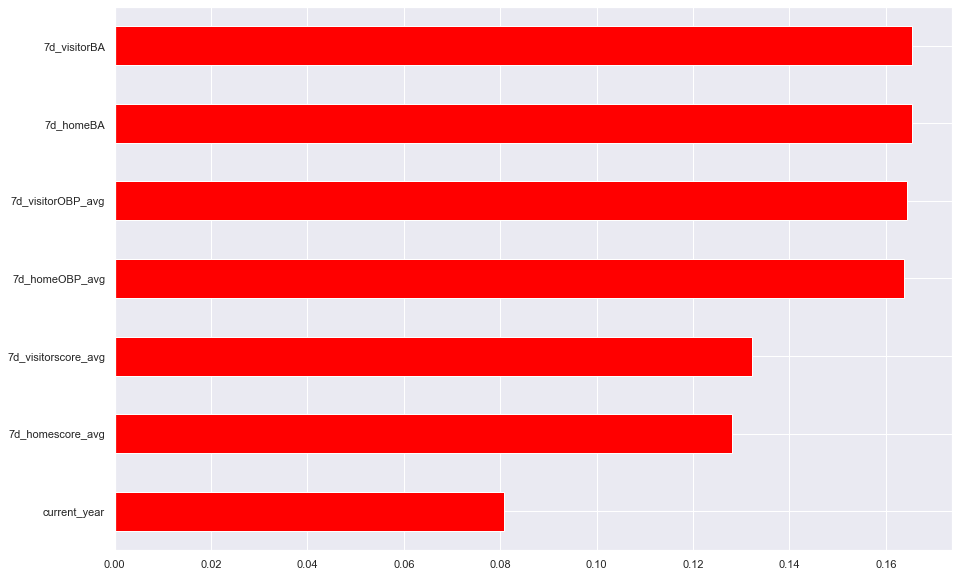

In [72]:
plot_features_importance(rf2_7, "red")

### It seemed like the 3d trends barely inched out the 7d trends by a fraction of a percent
### Going to try and model with:
    - historic trends & 3d
    - historic trends & 7d
    - historic trends with 3d & 7d trends

### Will train a RandomForest model on historitc team stats, 3d, and 7d trends.

In [73]:
# More or less the same features being dropped from before but adding 2 new features added to the game_df
new_drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP']

### Will leverage 3d trends first...

In [74]:
y = game_df['Home_team_won?']
# Drop usual features
X = game_df.drop(new_drop_lst, axis=1)
# Dropping the seven day trends
X = X.drop(seven_day_trends, axis=1)

In [75]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [76]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'atBats_y', 'team_BA_y',
       'totalBases_y', 'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y',
       'runs_y', 'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y',
       'baseOnBalls_y', 'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year',
       '3d_homeOBP_avg', '3d_visitorOBP_avg', '3d_homescore_avg',
       '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA'],
      dtype='objec

In [77]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [78]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,936,1355
True,796,1773


In [79]:
print(f"Accuracy for historic + 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 3d trends: 55.74%


In [80]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.81%


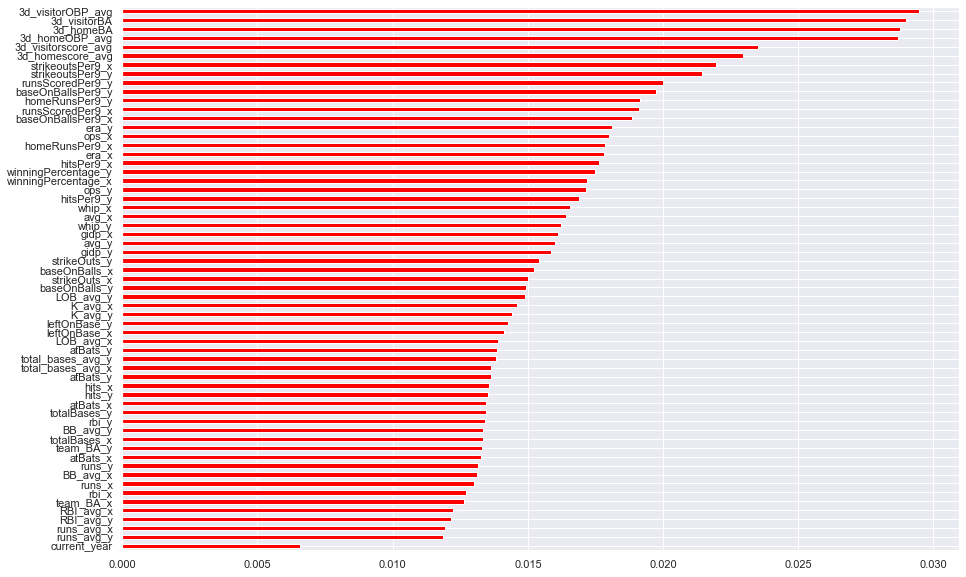

In [81]:
plot_features_importance(rf, "red")

### Now leverage 7d trends

In [82]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst, axis=1)
X = X.drop(three_day_trends, axis=1)

In [83]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [84]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'atBats_y', 'team_BA_y',
       'totalBases_y', 'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y',
       'runs_y', 'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y',
       'baseOnBalls_y', 'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year',
       '7d_homeOBP_avg', '7d_visitorOBP_avg', '7d_homescore_avg',
       '7d_visitorscore_avg', '7d_homeBA', '7d_visitorBA'],
      dtype='objec

In [85]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [86]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,965,1326
True,818,1751


In [87]:
print(f"Accuracy for historic + 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 7d trends: 55.88%


In [88]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 52.91%


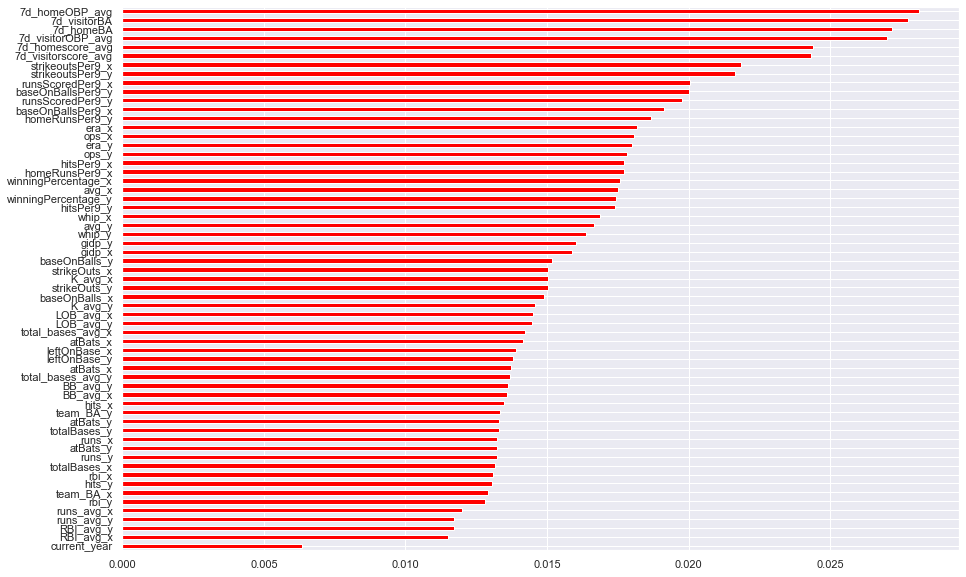

In [89]:
plot_features_importance(rf, "red")

## Now, model with historic, 3d, and 7d trends...

In [90]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst, axis=1)

In [91]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [92]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'atBats_y', 'team_BA_y',
       'totalBases_y', 'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y',
       'runs_y', 'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y',
       'baseOnBalls_y', 'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year',
       '3d_homeOBP_avg', '7d_homeOBP_avg', '3d_visitorOBP_avg',
       '7d_visitorOBP_avg', '3d_homescore_avg', '7d_homescore_avg',
       '3d_v

In [93]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [94]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,916,1375
True,773,1796


In [95]:
print(f"Accuracy for historic + 3d + 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 3d + 7d trends: 55.8%


In [96]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.45%


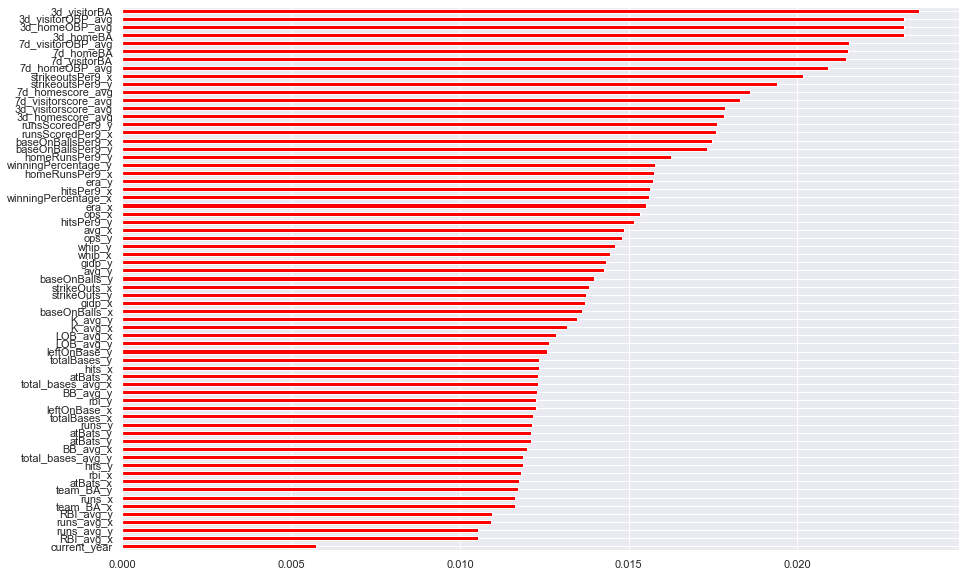

In [97]:
plot_features_importance(rf, "red")

# RandomForestClassifier seems to be working well with the new features that were added. Going to try out other models for comaprisons
- GradientBoostingClassifier (with and without GridSearchCV)
- AdaBoostClassifier

## Create a Train/Test split for the new models to leverage

In [98]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [99]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'atBats_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'atBats_y', 'team_BA_y',
       'totalBases_y', 'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y',
       'runs_y', 'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y',
       'baseOnBalls_y', 'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year',
       '3d_homeOBP_avg', '7d_homeOBP_avg', '3d_visitorOBP_avg',
       '7d_visitorOBP_avg', '3d_homescore_avg', '7d_homescore_avg',
       '3d_v

## GradientBoostingClassifier

In [100]:
gbc = GradientBoostingClassifier()

In [101]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [102]:
y_pred = gbc.predict(X_test)

In [103]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,843,1448
True,644,1925


In [104]:
print(f"Accuracy for GradientBoosting (OOB): {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for GradientBoosting (OOB): 56.95%


In [105]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gbc, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 54.68%


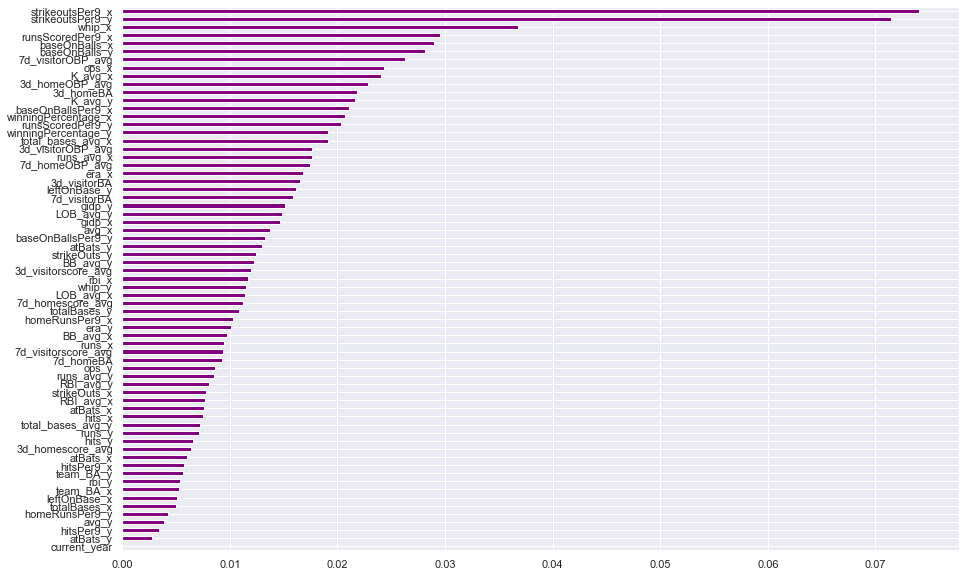

In [106]:
plot_features_importance(gbc, "purple")

## AdaBoostClassifier

In [107]:
abc = AdaBoostClassifier()

In [108]:
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [109]:
y_pred = abc.predict(X_test)

In [110]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,964,1327
True,832,1737


In [111]:
print(f"Accuracy for Adaboost: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for Adaboost: 55.58%


In [112]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(abc, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 54.31%


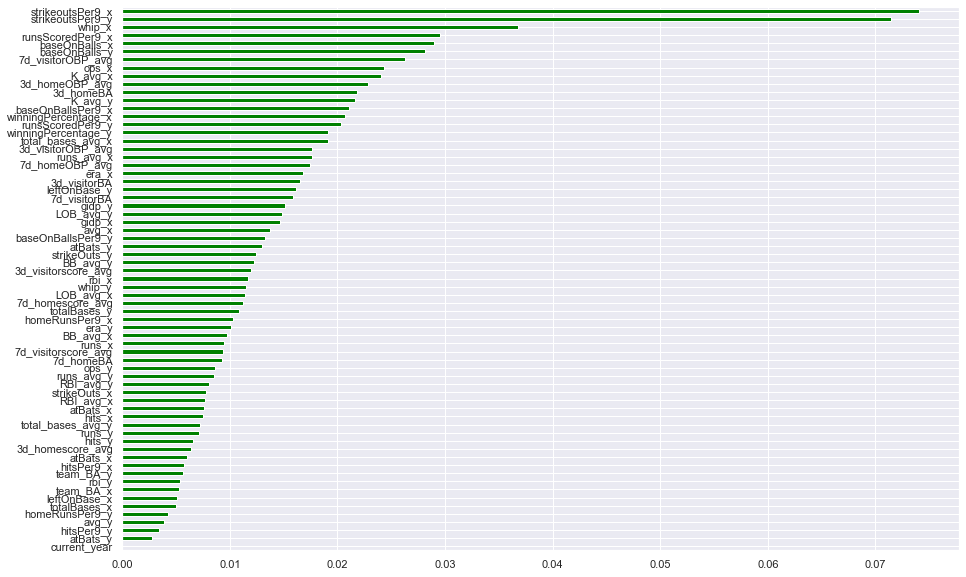

In [113]:
plot_features_importance(gbc, "green")

## GradientBoostingClassifier with GridSearchCV

In [114]:
# gbc = GradientBoostingClassifier()
# params_dict = {'learning_rate': [.0001, .001, .01, .1],
#                'n_estimators': [100,200,300,400,500,600,700]}
# grid_gbc = GridSearchCV(gbc, param_grid=params_dict, scoring='accuracy', cv=5, n_jobs=-1)
# grid_gbc.fit(X_train, y_train)
# best_param = grid_gbc.best_params_
# best_cv_score = grid_gbc.best_score_
# best_model = grid_gbc.best_estimator_
# test_acc = best_model.score(X_test, y_test)
# print(f"GradientBoosted with GridSearchCV accuracy: {round((test_acc*100),2)}%")

In [115]:
#print(f"Cross-validation score is: {round(np.mean(cross_val_score(grid_gbc, X_train, y_train, cv=5))*100, 2)}%")

In [116]:
game_df.columns

Index(['New_Date', 'VisitingTeam', 'VisitorStartingPitcherName', 'HomeTeam',
       'HomeStartingPitcherName', 'VisitorRunsScored', 'HomeRunsScore',
       'VisitorAB', 'VisitorH', 'Visitor_BA',
       ...
       '3d_visitorOBP_avg', '7d_visitorOBP_avg', '3d_homescore_avg',
       '7d_homescore_avg', '3d_visitorscore_avg', '7d_visitorscore_avg',
       '3d_homeBA', '7d_homeBA', '3d_visitorBA', '7d_visitorBA'],
      dtype='object', length=102)